In [21]:
!chmod +x run.sh

In [22]:
!./run.sh

mkdir: cannot create directory ‘build’: File exists
-- Configuring done
-- Generating done
-- Build files have been written to: /content/build
Consolidate compiler generated dependencies of target fht
[ 33%] Building CXX object CMakeFiles/fht.dir/main.cpp.o
[ 66%] Building CXX object CMakeFiles/fht.dir/fast_hough_transform.cpp.o
[100%] Linking CXX executable fht
[100%] Built target fht


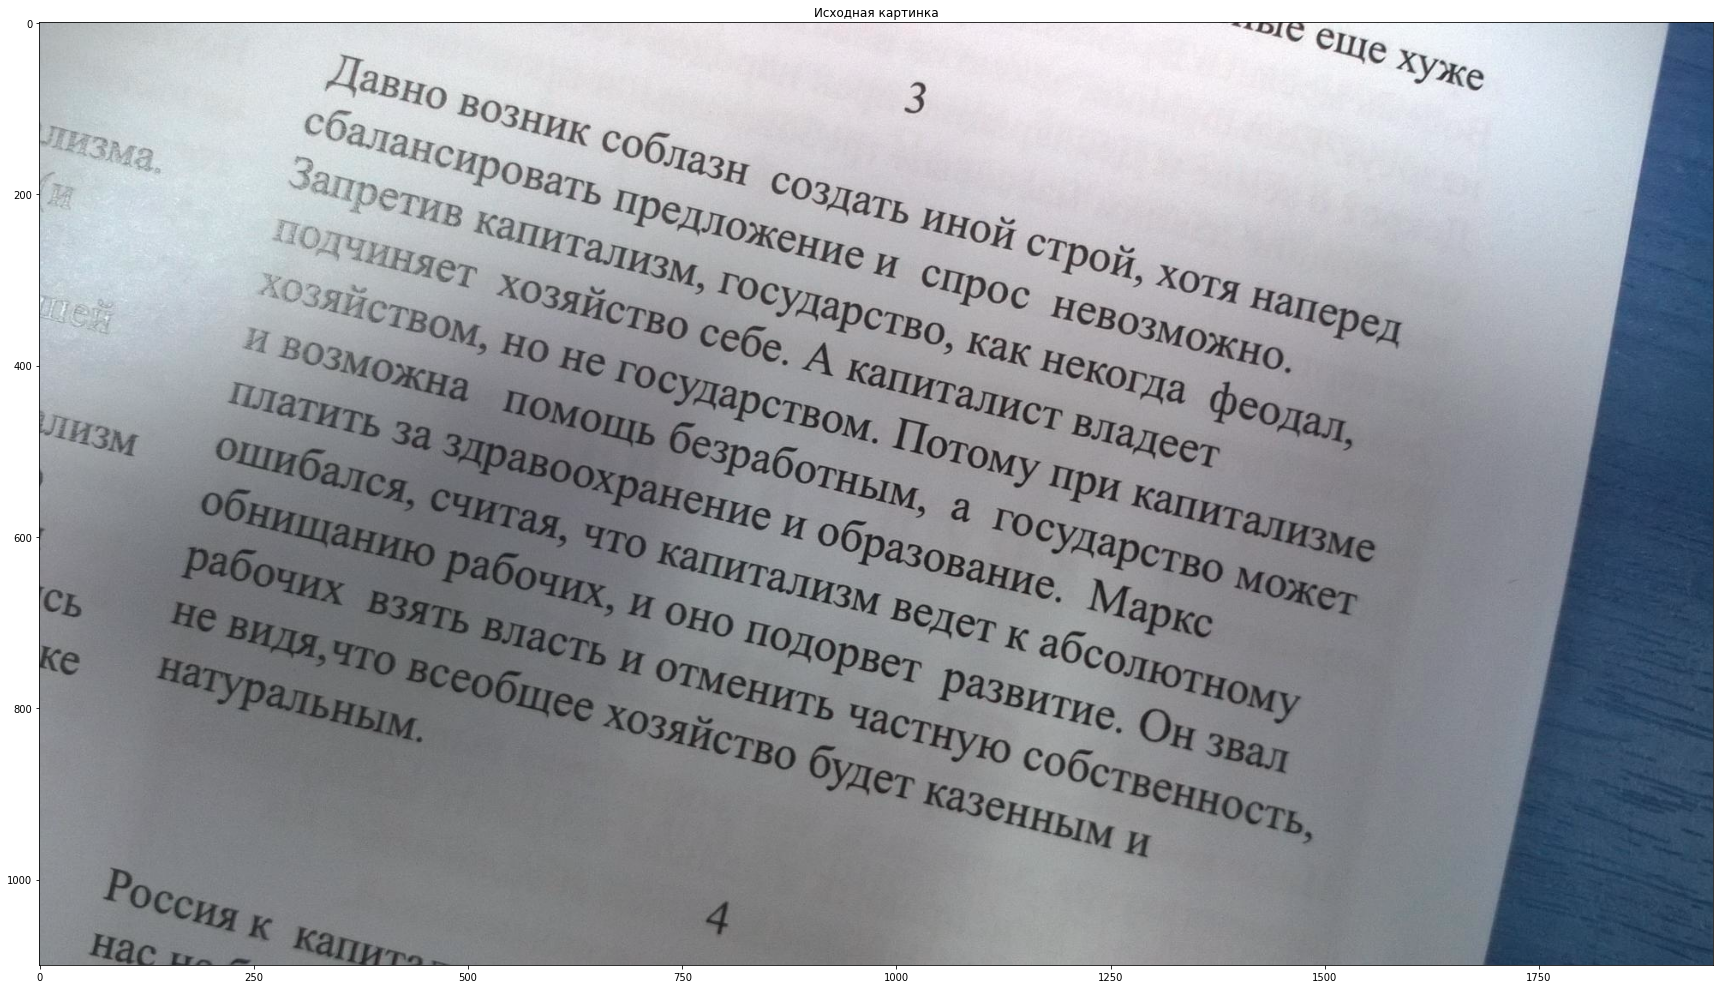

In [23]:
import cv2 as cv
import os
import numpy as np
import subprocess
import matplotlib.pyplot as plt


image_path = "img/1.jpg"
image = cv.imread(image_path)

plt.figure(figsize=(30,20))
plt.title("Исходная картинка")
plt.imshow(image);

In [24]:
args = ["./fht", image_path, "otuput_image.jpg"]
output = subprocess.run(args, shell=False, capture_output=True)
print(output.stdout.decode("utf-8"))


Slant angle = -10
Fast Hought transformation time = 6480 milliseconds/n



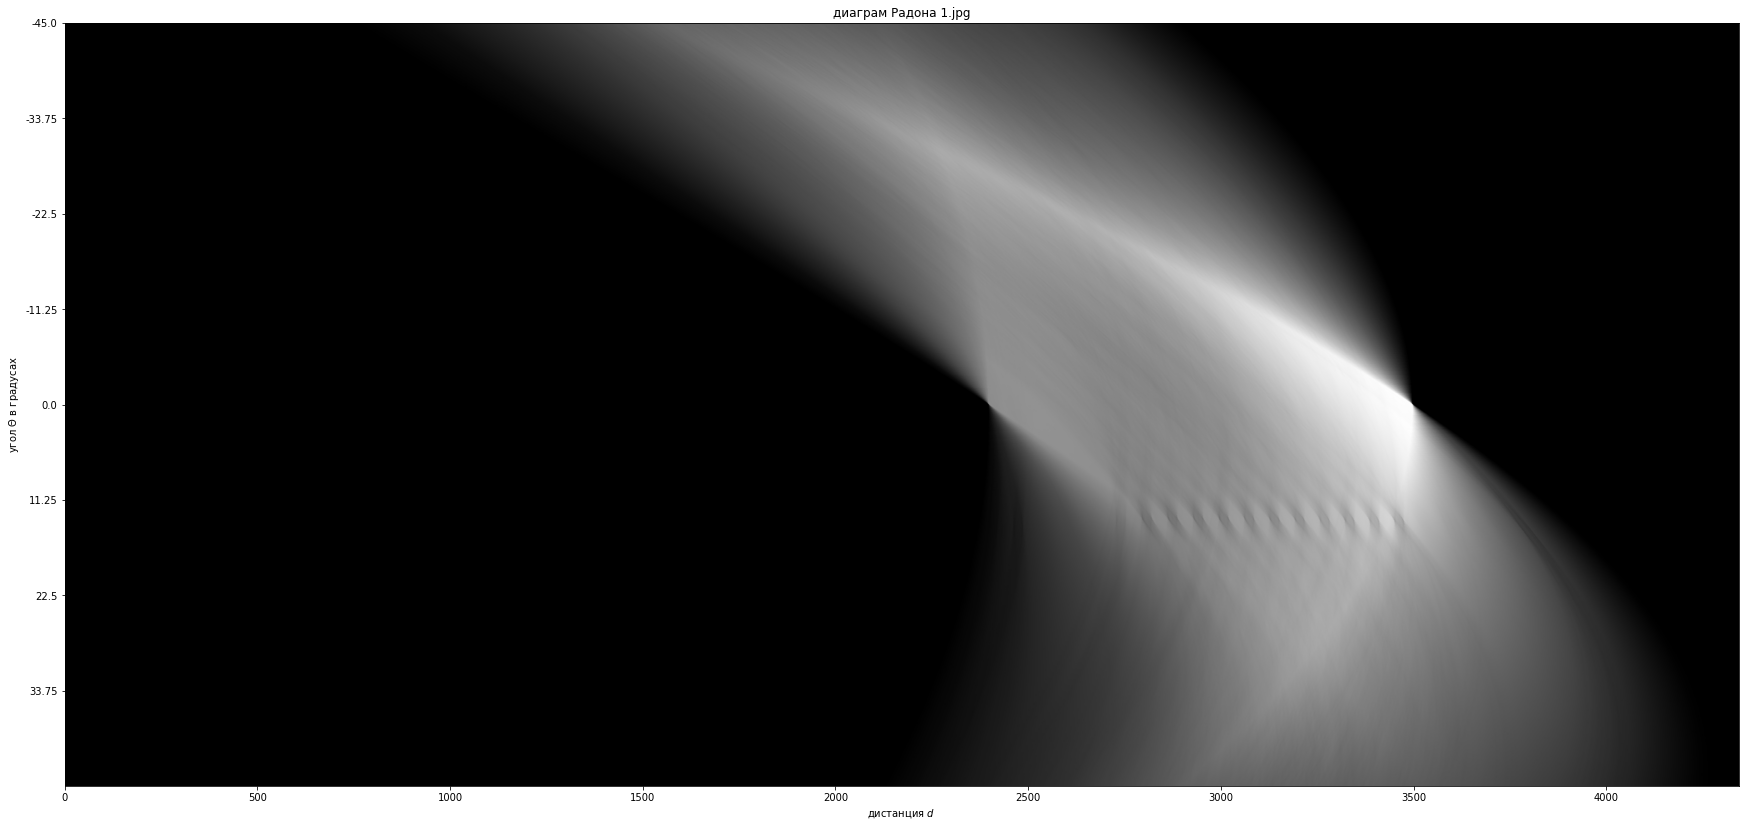

In [29]:
output_image = cv.imread("otuput_image.jpg")
plt.figure(figsize=(30,20))
plt.title(f"диаграм Радона {image_path.split('/')[-1]}")
plt.ylabel(r'угол $\Theta$ в градусах')
plt.yticks(np.arange(0, output_image.shape[0]+1, output_image.shape[0]/8), labels=np.arange(-90/2, 90/2+1, 90/8))
plt.xlabel(r'дистанция $d$')
plt.imshow(output_image);

**понятно, что из диаграммы Радона, можно заметит полосы на нижней части, и поятно, что угол наклон и соответствует гаризонтальной линии**

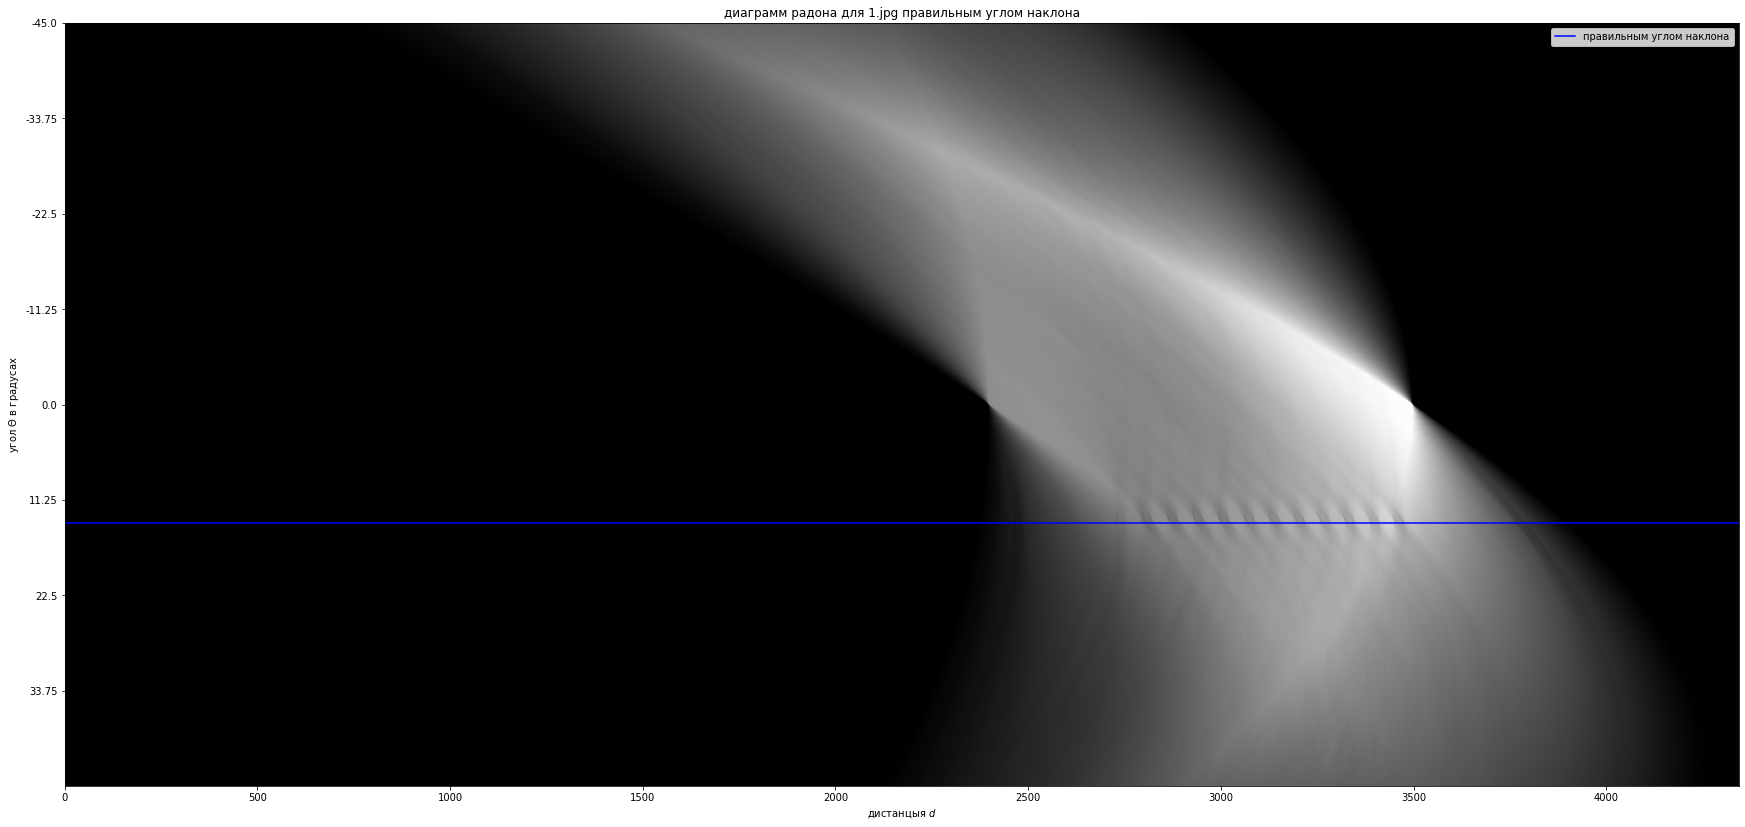

In [41]:
output_image = cv.imread("otuput_image.jpg")
plt.figure(figsize=(30,20))
plt.title(f"диаграмм радона для {image_path.split('/')[-1]} правильным углом наклона")
plt.ylabel(r'угол $\Theta$ в градусах')
plt.yticks(np.arange(0, output_image.shape[0]+1, output_image.shape[0]/8), labels=np.arange(-90/2, 90/2+1, 90/8))
plt.xlabel(r'дистанцыя $d$')

slant_angle = 14
plt.axhline(y=slant_angle*(output_image.shape[0]/90) + output_image.shape[0]/2, color='b',  linestyle='-', label='правильным углом наклона')

plt.legend()
plt.imshow(output_image);

1) ну так смотря можем заметить, эти полосы но алгоритмически их сложно найти, не какие *известные* метрики не находят в целом

2)можно например сделать предоброботку изображения, например полутоновую морфологию в филтром Собеля, но здесь возникает проблема, что параметры зависят от направления, то есть надо указать направление а для разных картинак эти направления различные что и усложняет нахождения параметром.

3)можно было например и подумать поповоду бинаризацыы диаграммы(так как может делать вершины различными), но на хоть маленьких шумах картинки может выдовать большие разницы, и на практике не очень оптимально исползовать.

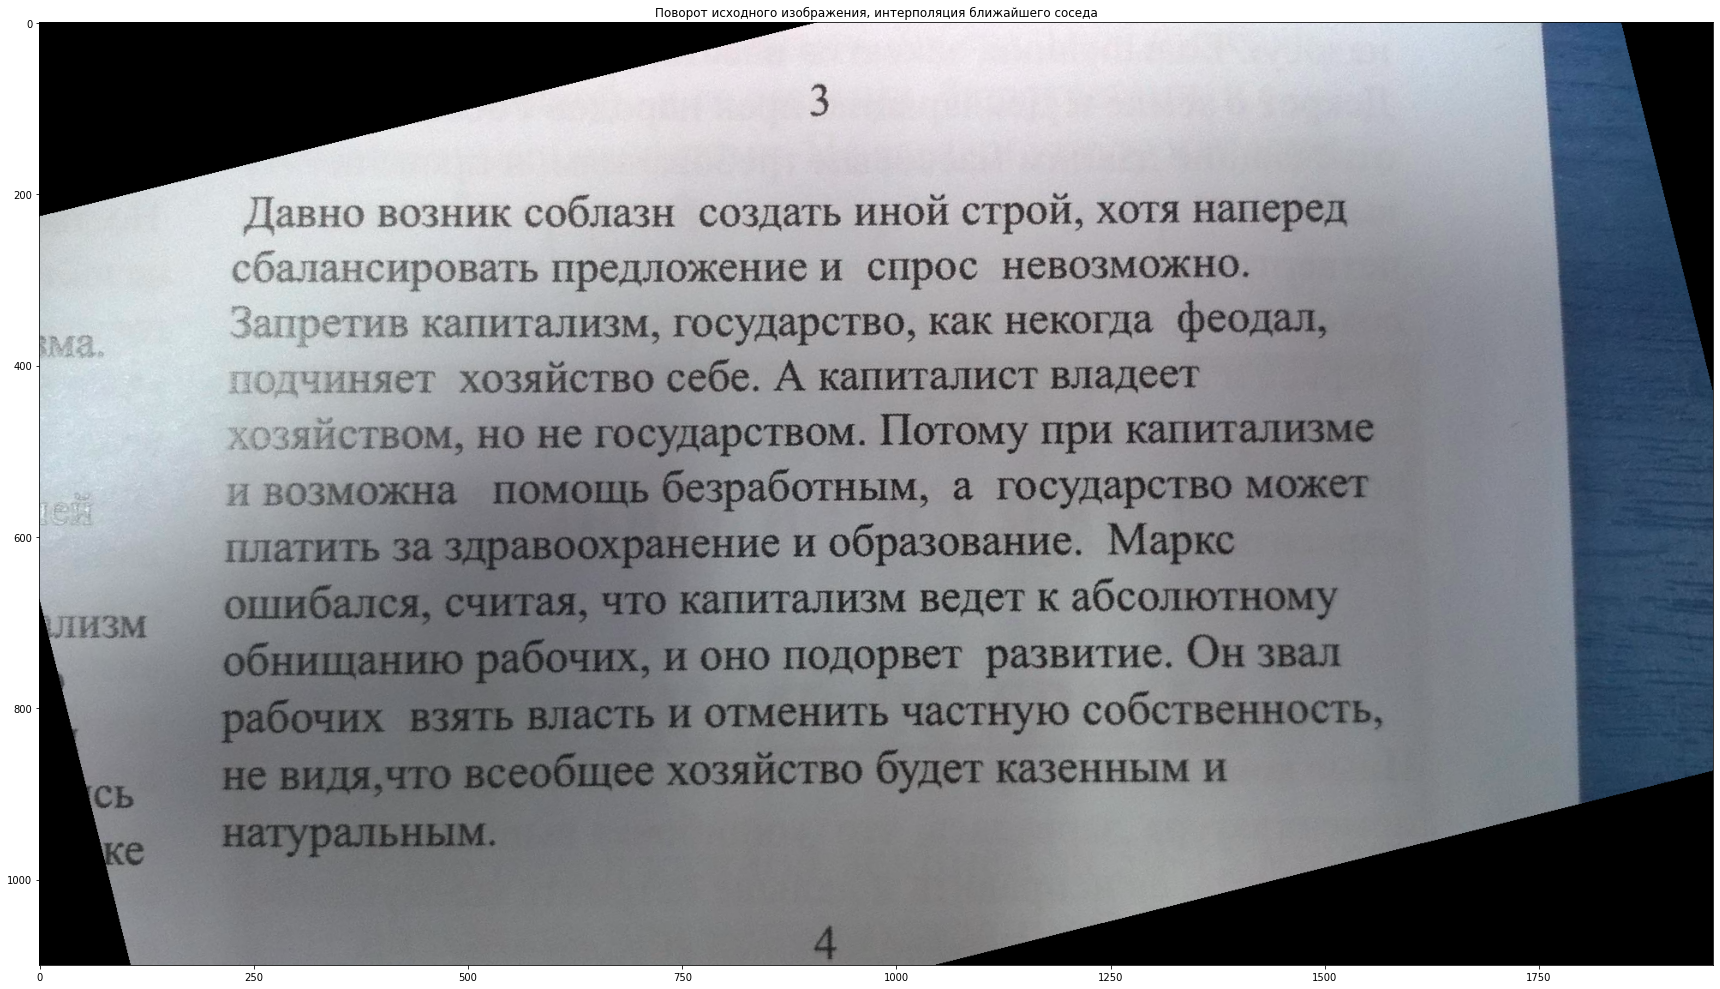

In [42]:
kernel = tuple(np.array(image.shape[1::-1]) / 2)
rot_mat = cv.getRotationMatrix2D(kernel, slant_angle, 1.0)
rotated = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_NEAREST)

plt.figure(figsize=(30,20))
plt.title(f"Поворот исходного изображения, интерполяция nearest neighbor") # 
plt.imshow(rotated);


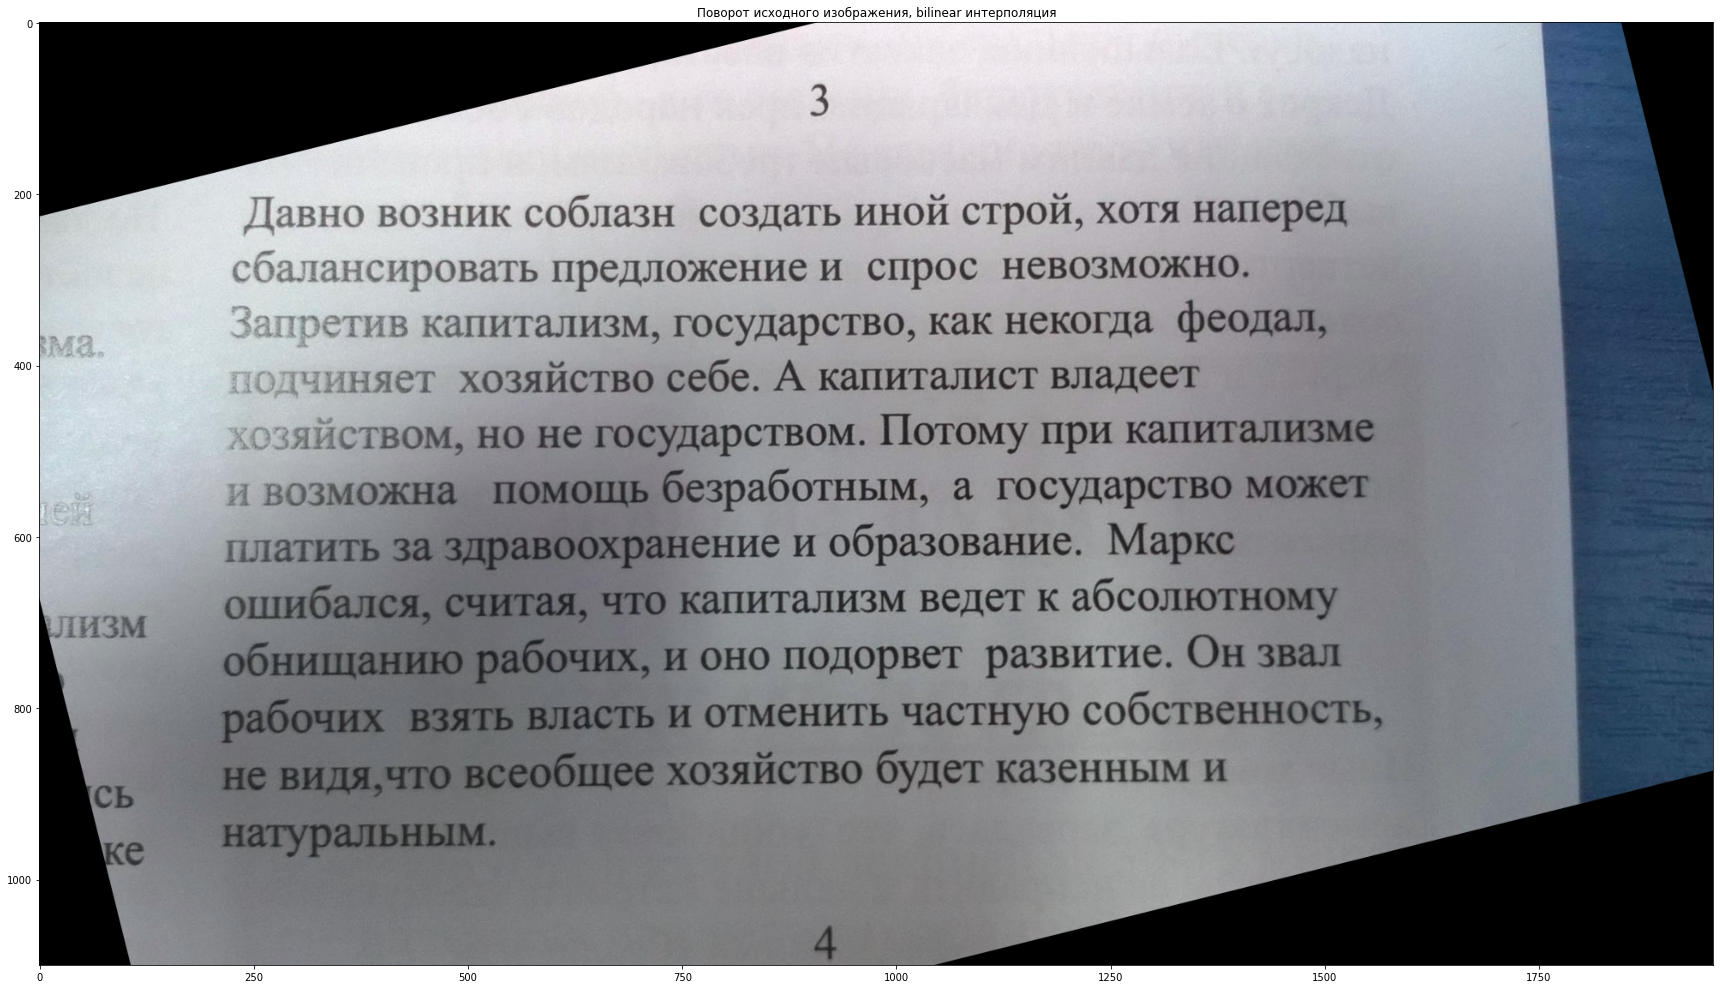

In [45]:
rotated = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)

plt.figure(figsize=(30,20))
plt.title(f"Поворот исходного изображения, bilinear интерполяция")
plt.imshow(rotated);

In [57]:
from tqdm import tqdm

new_image = cv.imread("img/9.jpg")
rows_cols = new_image.shape[1]/new_image.shape[0]

megapixels = np.arange(1, new_image.size // 1e6 + 1, 1)
total_times = []

for megapixel in tqdm(megapixels):
    rows = np.sqrt(megapixel * 1e6 / (new_image.shape[2] * rows_cols))
    cols = rows * rows_cols
    
    cv.imwrite("new_image.jpg", new_image[:int(rows), :int(cols), :])
    
    args = ["./fht", "new_image.jpg", "output_image.jpg"]
    output = subprocess.run(args, shell=False, capture_output=True)
    total_time.append(int(output.stdout.decode("utf-8").split()[-2]))

100%|██████████| 34/34 [13:11<00:00, 23.27s/it]


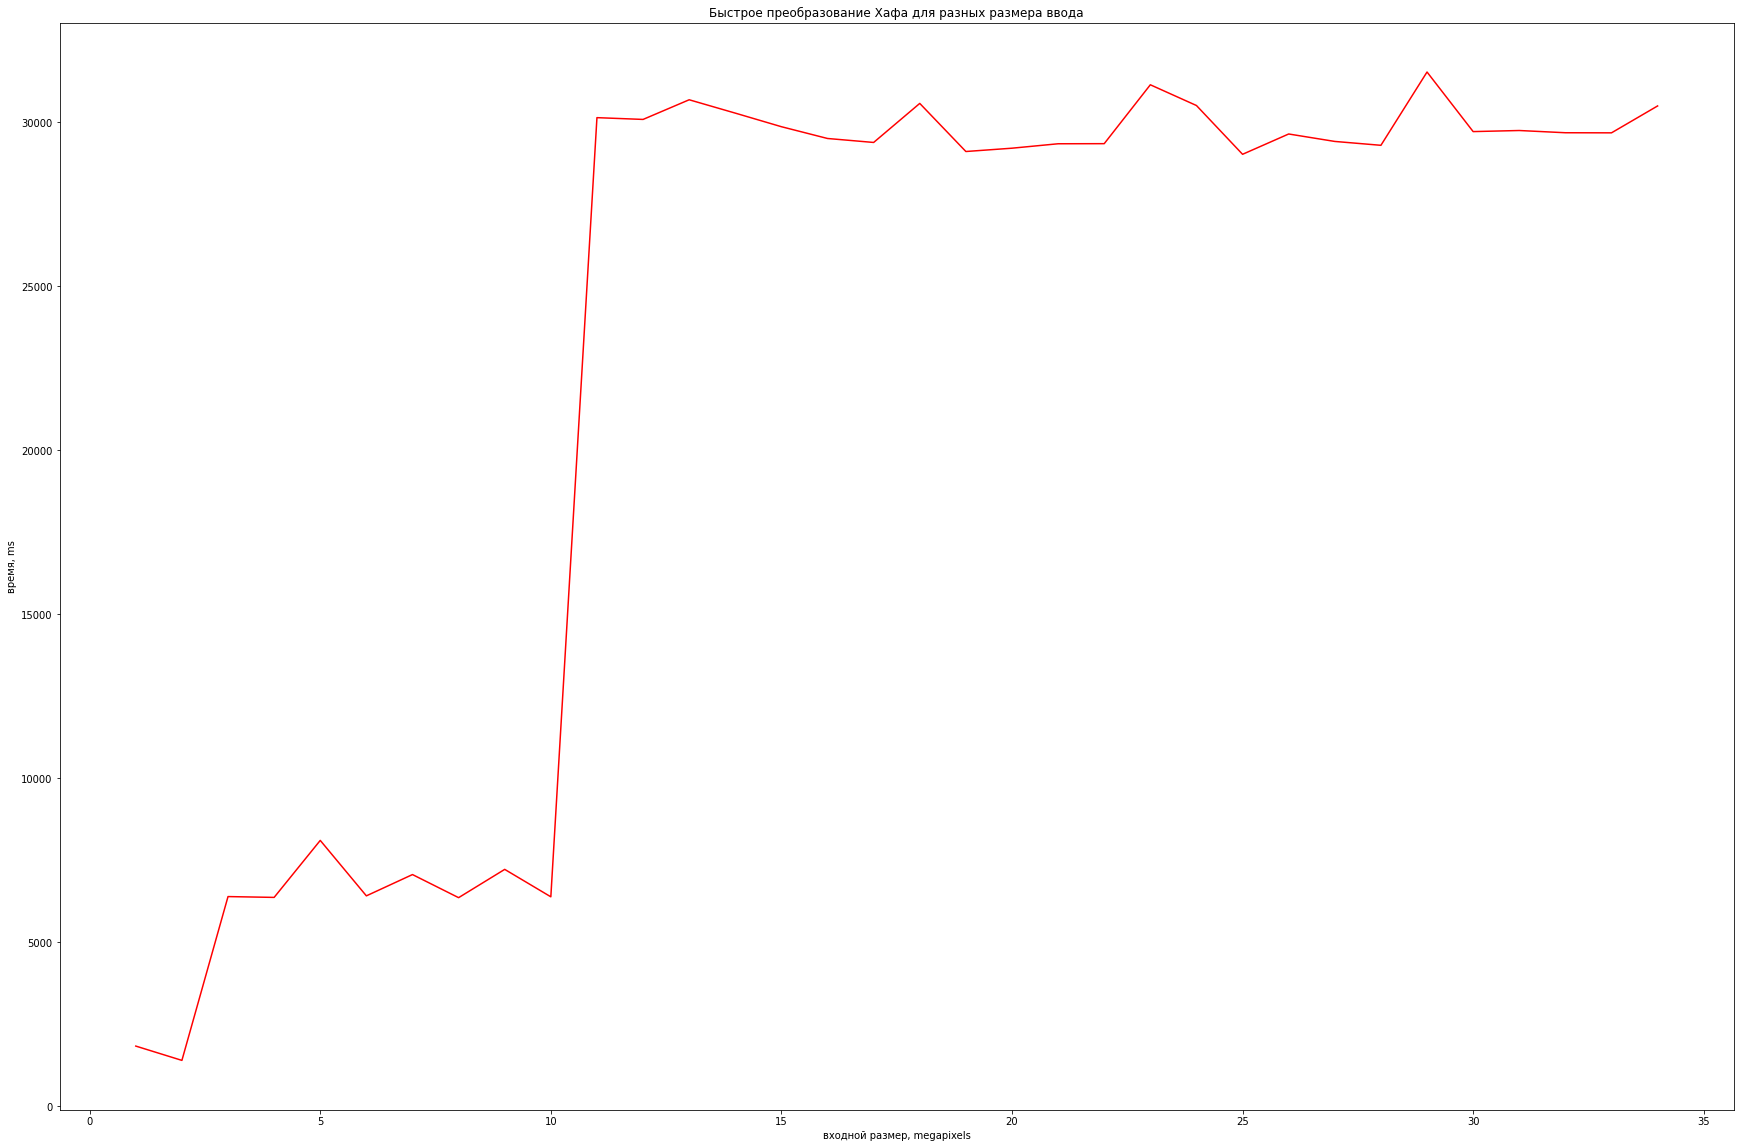

In [59]:
plt.figure(figsize=(30,20))

plt.plot(megapixels, total_time, 'red')

plt.title(f"Быстрое преобразование Хафа для разных размера ввода")
plt.ylabel('время, ms')
plt.xlabel('входной размер, megapixels')
plt.show()


**у графика, есть скачки так как когда высота или ширина превышать текущий степень двойки, то через бистрое преоброзование мы увелечываем размер изоброжения до новой степени двойки, а на каждый раз мы делаем тоже самые вычесление, то есть время не меняется, и тогда можем заметить возвышенность** 

# Ассимптотика

**Итоговая ассимптотика состаит из нескольких этапов:**

1) Расширение изображения до ближайшей степени двойки	
2) Быстрое преобразование Хафа для одной четверти \\
3) Создание и заполнение диаграммы Радона \\
4) Вычисление угла поворота по диаграмме \\


* что касается **памяти**, то для все этапов используем ${N^2}$

* что касается **времени вычесления** кроме второго этапа мы исползуем ${N^2}$, а во втором ${N^2}*log{N}$.

итого мы испольовали ${N^2}$. *памяти* и ${N^2}*log{N}$ *время*
.
